In [1]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor,SegformerImageProcessor,AdamW
import pandas as pd
import cv2
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import albumentations as aug
import matplotlib.pyplot as plt
from torch.nn.functional import binary_cross_entropy_with_logits

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        super(CustomDataset,self).__init__()
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms
        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "pngmasks")
        image_file_names = []
        for _, _, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        annotation_file_names = []
        for _, _, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        return encoded_inputs

In [3]:
transform = aug.Compose([
    aug.Flip(p=0.5)
    #aug.Normalize(max_pixel_value=255.0,mean=[0.0,0.0,0.0],std=[1.0,1.0,1.0])
],is_check_shapes=False)

In [4]:
train_dir =r"D:\graval detection project\datasets\under_water_masks_dataset\train"
valid_dir=r"D:\graval detection project\datasets\under_water_masks_dataset\val"
test_dir=r"D:\graval detection project\datasets\under_water_masks_dataset\test"
feature_extractor = SegformerFeatureExtractor (align=False, reduce_zero_label=False,do_rescale=False)
train_dataset = CustomDataset(root_dir=train_dir, feature_extractor=feature_extractor, transforms=None)
valid_dataset = CustomDataset(root_dir=valid_dir, feature_extractor=feature_extractor, transforms=None, train=False)
#test_dataset = CustomDataset(root_dir=test_dir, feature_extractor=feature_extractor, transforms=transform, train=False)

c:\Program Files\Python310\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


In [5]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=1,shuffle=False)
#test_dataloader=DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)

In [6]:
print("Number of training examples:", len(train_dataset))

Number of training examples: 580


In [7]:
encoded_inputs = train_dataset[0]

In [8]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [9]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [10]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [11]:
encoded_inputs["labels"].squeeze().unique()

tensor([  0, 255])

In [12]:
mask = encoded_inputs["labels"].numpy()

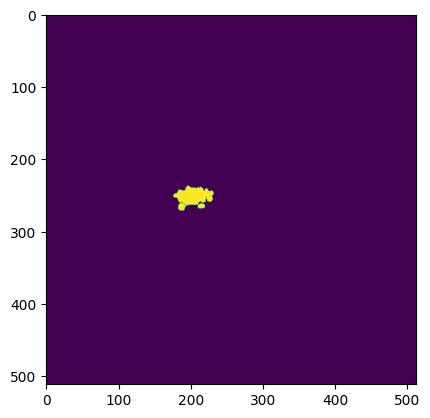

In [13]:
plt.imshow(mask)

In [14]:
classes=["background","stone"]
id2label = {
    classes[0]: (0, 0, 0),    # background pixel
    classes[1]: (255, 255, 255)  # stone
}
label2id = {value: key for key, value in id2label.items()}

In [15]:
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         reshape_last_stage=True)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.running_mean', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.classifier.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_fuse.weight', 'decode_head.batch_norm.bias', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_var', 'decode_head.linear_c.1.proj.weight', 'decode_head.batch_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
for para in model.parameters():
    para.requires_grad=True

In [17]:
summary(model=model)

Layer (type:depth-idx)                                                      Param #
SegformerForSemanticSegmentation                                            --
├─SegformerModel: 1-1                                                       --
│    └─SegformerEncoder: 2-1                                                --
│    │    └─ModuleList: 3-1                                                 485,472
│    │    └─ModuleList: 3-2                                                 2,832,896
│    │    └─ModuleList: 3-3                                                 1,024
├─SegformerDecodeHead: 1-2                                                  --
│    └─ModuleList: 2-2                                                      --
│    │    └─SegformerMLP: 3-4                                               8,448
│    │    └─SegformerMLP: 3-5                                               16,640
│    │    └─SegformerMLP: 3-6                                               41,216
│    │    └─Segformer

In [18]:
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")

c:\Program Files\Python310\lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Model Initialized!


In [19]:
for epoch in range(1, 11):
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)
        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(train_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)
                mask = (labels != 255) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())
    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")

Epoch: 1


  0%|          | 0/580 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
"""for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()

    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)

        # calculate binary cross-entropy loss
        loss = binary_cross_entropy_with_logits(outputs.logits, labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)
        mask = (labels != 255)  # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies) / len(accuracies), 'Loss': sum(losses) / len(losses)})

        # backward + optimize
        loss.backward()
        optimizer.step()

    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)

                mask = (labels != 255)  # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = binary_cross_entropy_with_logits(outputs.logits, labels)
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())

    print(f"Train Pixel-wise accuracy: {sum(accuracies) / len(accuracies)}\
         Train Loss: {sum(losses) / len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies) / len(val_accuracies)}\
         Val Loss: {sum(val_losses) / len(val_losses)}")"""

In [ ]:
def binary_metrics(pred, target):
    # Convert to binary labels (0/1)
    pred = (pred > 0.5).float()
    target = target.float()
    
    # Calculate metrics
    acc = accuracy_score(pred.cpu().numpy(), target.cpu().numpy())
    auc = roc_auc_score(target.cpu().numpy(), pred.cpu().numpy())
    recall = recall_score(target.cpu().numpy(), pred.cpu().numpy())
    precision = precision_score(target.cpu().numpy(), pred.cpu().numpy())
    return acc, auc, recall, precision

In [ ]:
for epoch in range(1, 11):
    print(f"Epoch: {epoch}")
    pbar = tqdm(train_dataloader)
    accuracies = []
    aucs = []
    recalls = []
    precisions = []
    losses = []    
    model.train()
    for idx, batch in enumerate(pbar):
        # Get inputs and labels
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device).float()
        # Zero gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(pixel_values=pixel_values, labels=labels)
        # Calculate binary cross entropy loss
        loss = binary_cross_entropy_with_logits(outputs.logits, labels)
        # Evaluate and update metrics
        acc, auc, recall, precision = binary_metrics(outputs.logits, labels)
        accuracies.append(acc)
        aucs.append(auc)
        recalls.append(recall)
        precisions.append(precision)
        losses.append(loss.item())
        pbar.set_postfix({
            "Batch": idx,
            "Pixel-wise Accuracy": sum(accuracies) / len(accuracies),
            "AUC": sum(aucs) / len(aucs),
            "Recall": sum(recalls) / len(recalls),
            "Precision": sum(precisions) / len(precisions),
            "Loss": sum(losses) / len(losses),
        })

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    # Validation loop
    with torch.no_grad():
        val_accuracies, val_aucs, val_recalls, val_precisions, val_losses = [], [], [], [], []
        model.eval()
        for idx, batch in enumerate(valid_dataloader):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device).float()
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = binary_cross_entropy_with_logits(outputs.logits, labels)
            acc, auc, recall, precision = binary_metrics(outputs.logits, labels)
            val_accuracies.append(acc)
            val_aucs.append(auc)
            val_recalls.append(recall)
            val_precisions.append(precision)
            val_losses.append(loss.item())
        print(f"Train Pixel-wise Accuracy: {sum(accuracies) / len(accuracies)}\
            Train AUC: {sum(aucs) / len(aucs)}\
            Train Recall: {sum(recalls) / len(recalls)}\
            Train Precision: {sum(precisions) / len(precisions)}\
            Train Loss: {sum(losses) / len(losses)}\n\
            Val Pixel-wise Accuracy: {sum(val_accuracies) / len(val_accuracies)}\
            Val AUC: {sum(val_aucs) / len(val_aucs)}\
            Val Recall: {sum(val_recalls) / len(val_recalls)}\
            Val Precision:{sum(val_precisions) / len(val_precisions)}\
            Val loss:{sum(val_losses) / len(val_losses)}")


In [ ]:
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from tqdm.notebook import tqdm
import os
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor,SegformerImageProcessor,AdamW
import pandas as pd
import cv2
import numpy as np
from torch.utils.data import DataLoader
from torchinfo import summary
import albumentations as aug
from torch.nn.functional import binary_cross_entropy_with_logits
class CustomDataset(Dataset):
    def __init__(self, root_dir, feature_extractor, transforms=None, train=True):
        super(CustomDataset,self).__init__()
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train
        self.transforms = transforms
        self.img_dir = os.path.join(self.root_dir, "images")
        self.ann_dir = os.path.join(self.root_dir, "masks")
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
            image_file_names.extend(files)
        self.images = sorted(image_file_names)
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
            annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)
        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        image = cv2.imread(os.path.join(self.img_dir, self.images[idx]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        segmentation_map = cv2.imread(os.path.join(self.ann_dir, self.annotations[idx]))
        segmentation_map = cv2.cvtColor(segmentation_map, cv2.COLOR_BGR2GRAY)
        if self.transforms is not None:
            augmented = self.transforms(image=image, mask=segmentation_map)
            encoded_inputs = self.feature_extractor(augmented['image'], augmented['mask'], return_tensors="pt")
        else:
            encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")
        for k,v in encoded_inputs.items():
            encoded_inputs[k].squeeze_()
        return encoded_inputs
transform = aug.Compose([
    #aug.Flip(p=0.5)
    aug.Normalize(max_pixel_value=255.0,mean=[0.0,0.0,0.0],std=[1.0,1.0,1.0])
],is_check_shapes=False)
train_dir =r"D:\graval detection project\datasets\under_water_masks_dataset\train"
valid_dir=r"D:\graval detection project\datasets\under_water_masks_dataset\val"
test_dir=r"D:\graval detection project\datasets\under_water_masks_dataset\test"
feature_extractor = SegformerFeatureExtractor (align=False, reduce_zero_label=False,do_rescale=False)
train_dataset = CustomDataset(root_dir=train_dir, feature_extractor=feature_extractor, transforms=transform)
valid_dataset = CustomDataset(root_dir=valid_dir, feature_extractor=feature_extractor, transforms=transform, train=False)
test_dataset = CustomDataset(root_dir=test_dir, feature_extractor=feature_extractor, transforms=transform, train=False)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=1,shuffle=False)
test_dataloader=DataLoader(dataset=test_dataset,batch_size=1,shuffle=False)
classes = ["stone"]
print(classes)
id2label = {1:classes[0]}
print(id2label)
label2id = {v: k for k, v in id2label.items()}
print(label2id)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5", ignore_mismatched_sizes=True,
                                                         num_labels=len(classes),id2label=id2label,label2id=label2id,
                                                         reshape_last_stage=True)
for para in model.parameters():
    para.requires_grad=True
summary(model=model)
optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model Initialized!")
for epoch in range(1, 11):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    pbar = tqdm(train_dataloader)
    accuracies = []
    losses = []
    val_accuracies = []
    val_losses = []
    model.train()
    for idx, batch in enumerate(pbar):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model(pixel_values=pixel_values, labels=labels)
        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1.0)
        mask = (labels != 1) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        accuracy = accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        accuracies.append(accuracy)
        losses.append(loss.item())
        pbar.set_postfix({'Batch': idx, 'Pixel-wise accuracy': sum(accuracies)/len(accuracies), 'Loss': sum(losses)/len(losses)})
        # backward + optimize
        loss.backward()
        optimizer.step()
    else:
        model.eval()
        with torch.no_grad():
            for idx, batch in enumerate(valid_dataloader):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(pixel_values=pixel_values, labels=labels)
                upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
                predicted = upsampled_logits.argmax(dim=1)
                mask = (labels != 1.0) # we don't include the background class in the accuracy calculation
                pred_labels = predicted[mask].detach().cpu().numpy()
                true_labels = labels[mask].detach().cpu().numpy()
                accuracy = accuracy_score(pred_labels, true_labels)
                val_loss = outputs.loss
                val_accuracies.append(accuracy)
                val_losses.append(val_loss.item())
    print(f"Train Pixel-wise accuracy: {sum(accuracies)/len(accuracies)}\
         Train Loss: {sum(losses)/len(losses)}\
         Val Pixel-wise accuracy: {sum(val_accuracies)/len(val_accuracies)}\
         Val Loss: {sum(val_losses)/len(val_losses)}")